#### Based on Elise Olson's https://github.com/SalishSeaCast/analysis-elise-2/blob/master/notebooks/modelEqs/NewRateComparison.ipynb notebook

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import bio_tools as bt, places
import xarray as xr
import os
import glob
%matplotlib inline

In [2]:
nml=bt.load_nml_bio(resDir='/ocean/eolson/MEOPAR/NEMO-3.6-code/NEMOGCM/CONFIG/SalishSeaCast/EXP00/',
                 nmlname='nampisprod',bioRefName='namelist_smelt_cfg_HC201905equiv',bioCfgName='namelist_smelt_cfg_HC201905equiv')

In [3]:
nml

Namelist([('zz_rate_r_diat', 6.0495e-05),
          ('zz_rate_r_myri', 2.22e-05),
          ('zz_rate_r_nano', 2.109e-05),
          ('zz_rate_maxtemp_diat', 26.0),
          ('zz_rate_maxtemp_myri', 31.0),
          ('zz_rate_maxtemp_nano', 31.0),
          ('zz_rate_temprange_diat', 14.0),
          ('zz_rate_temprange_myri', 13.0),
          ('zz_rate_temprange_nano', 13.0),
          ('zz_rate_iopt_diat', 45.0),
          ('zz_rate_iopt_myri', 37.0),
          ('zz_rate_iopt_nano', 10.0),
          ('zz_rate_gamma_diat', 0.0),
          ('zz_rate_gamma_myri', 0.0),
          ('zz_rate_gamma_nano', 0.0),
          ('zz_rate_k_si_diat', 2.2),
          ('zz_rate_k_si_myri', 0.0),
          ('zz_rate_k_si_nano', 0.0),
          ('zz_rate_kapa_diat', 1.0),
          ('zz_rate_kapa_myri', 0.5),
          ('zz_rate_kapa_nano', 0.3),
          ('zz_rate_k_diat', 2.0),
          ('zz_rate_k_myri', 0.5),
          ('zz_rate_k_nano', 0.2),
          ('zz_rate_si_ratio_diat', 1.8),
          

In [4]:
def phyto_Tdep_Factor(TT, zz_rate_maxtemp, zz_rate_temprange):
    if hasattr(TT,'__len__'): # assume 1-d array or similar and return array
        return np.array([phyto_Tdep_Factor(el,zz_rate_maxtemp, zz_rate_temprange) for el in TT])
    else:
        return np.exp(0.07 * (TT - 20)) * min(max((zz_rate_maxtemp - TT), 0.0),zz_rate_temprange) / (zz_rate_temprange + 1e-10)

In [5]:
def calc_T_Factors(TT,nampisprod):
    Tdep_Diat=phyto_Tdep_Factor(TT,nampisprod['zz_rate_maxtemp_diat'],nampisprod['zz_rate_temprange_diat'])
    Tdep_Myri=phyto_Tdep_Factor(TT,nampisprod['zz_rate_maxtemp_myri'],nampisprod['zz_rate_temprange_myri'])
    Tdep_Nano=phyto_Tdep_Factor(TT,nampisprod['zz_rate_maxtemp_nano'],nampisprod['zz_rate_temprange_nano'])
    return Tdep_Diat, Tdep_Myri, Tdep_Nano

Text(0.5, 1.0, 'Temperature response of diatoms and flagellates')

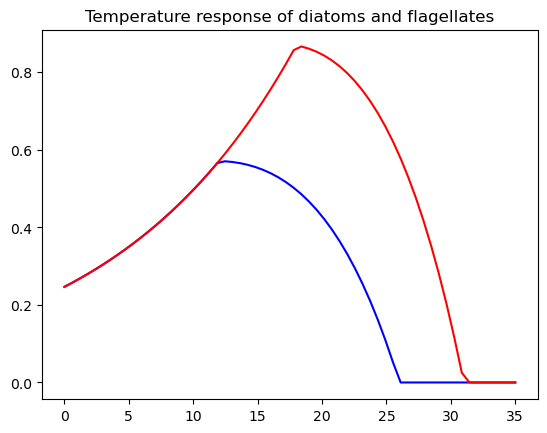

In [6]:
t=np.linspace(0,35,60)
TdepD,TdepM,TdepF=calc_T_Factors(t,nml)
plt.plot(t,TdepD,'b-')
plt.plot(t,TdepF,'r-')
plt.title('Temperature response of diatoms and flagellates')

In [7]:
#years, months, data
monthly_array_temp_orig_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['votemper']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

### 2008 using higher temperature threshold       
# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            q = ds.votemper.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_temp_orig_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['votemper']:
                data[var].append(ds.votemper.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)


In [8]:
monthly_array_temp_orig_slice[monthly_array_temp_orig_slice == 0 ] = np.nan
monthly_array_temp_orig_slicemean = \
np.nanmean(np.nanmean(monthly_array_temp_orig_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_temp_orig_slicemean))

(14, 12)


/tmp/ipykernel_1104006/1734163470.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_temp_orig_slice, axis = 2),axis = 2)


In [9]:
#years, months, data
monthly_array_temp_exp_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['votemper']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

### 2008 using higher temperature threshold       
# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 7):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/Karyn/01jan19_river08/SalishSea_1m_{datestr}_{datestr}'
        
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            q = ds.votemper.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_temp_exp_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['votemper']:
                data[var].append(ds.votemper.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(7, 10):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/Karyn/01jul19_river08/SalishSea_1m_{datestr}_{datestr}'
        
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            q = ds.votemper.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_temp_exp_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['votemper']:
                data[var].append(ds.votemper.isel(deptht=0, **slc).values)
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

In [10]:
monthly_array_temp_exp_slice[monthly_array_temp_exp_slice == 0 ] = np.nan
monthly_array_temp_exp_slicemean = \
np.nanmean(np.nanmean(monthly_array_temp_exp_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_temp_exp_slicemean))

(14, 12)


/tmp/ipykernel_1104006/2338418733.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_temp_exp_slice, axis = 2),axis = 2)


In [11]:
monthly_array_temp_exp_slicemean[1,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [12]:
monthly_array_temp_orig_slicemean[1,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Text(0.5, 1.0, '2019 temperature by month')

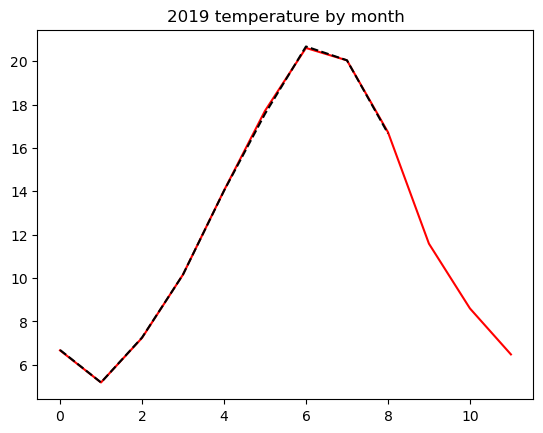

In [13]:
plt.plot(monthly_array_temp_orig_slicemean[12,:],'r-')
plt.plot(monthly_array_temp_exp_slicemean[12,:],'k--')
plt.title('2019 temperature by month')

In [14]:
TdepDiatOrig,__,TdepNanoOrig=calc_T_Factors(monthly_array_temp_orig_slicemean[12,:],nml)
TdepDiatExp,__,TdepNanoExp=calc_T_Factors(monthly_array_temp_exp_slicemean[12,:],nml)

### Temperature response factors


Text(0.5, 0, 'Month')

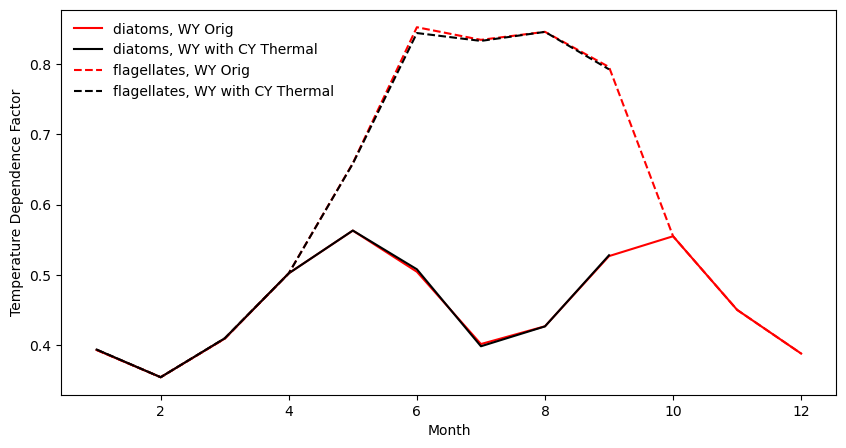

In [15]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
months=np.arange(1,13)
ax.plot(months,TdepDiatOrig,'r-',label='diatoms, WY Orig')
ax.plot(months,TdepDiatExp,'k-',label='diatoms, WY with CY Rivers')
ax.plot(months,TdepNanoOrig,'r--',label='flagellates, WY Orig')
ax.plot(months,TdepNanoExp,'k--',label='flagellates, WY with CY Rivers')
ax.legend(frameon=False)
ax.set_ylabel('Temperature Dependence Factor')
ax.set_xlabel('Month')

### Ratio of Diatom:Flagellate Temperature Response Factors

Text(0.5, 0, 'Month')

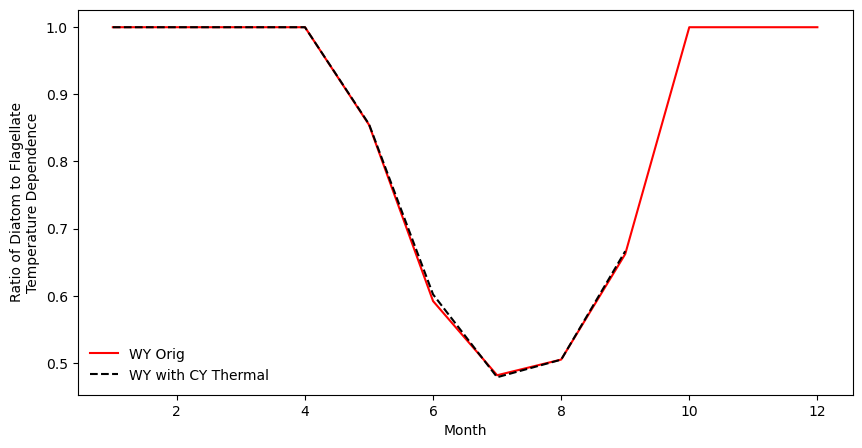

In [16]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
months=np.arange(1,13)
ax.plot(months,TdepDiatOrig/TdepNanoOrig,'r-',label='WY Orig')
ax.plot(months,TdepDiatExp/TdepNanoExp,'k--',label='WY with CY Rivers')
ax.legend(frameon=False)
ax.set_ylabel('Ratio of Diatom to Flagellate\nTemperature Dependence')
ax.set_xlabel('Month')

#### Open Nitrate files

In [17]:

#years, months, data
monthly_array_nitrate_orig_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
        
# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_orig_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['nitrate']:
                data[var].append(ds.nitrate.isel(deptht=0, **slc).values)
                
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)        


In [18]:
monthly_array_nitrate_orig_slice[monthly_array_nitrate_orig_slice == 0 ] = np.nan
monthly_array_nitrate_orig_slicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_orig_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_orig_slicemean))

(14, 12)


/tmp/ipykernel_1104006/3312634990.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_nitrate_orig_slice, axis = 2),axis = 2)


In [20]:

#years, months, data
monthly_array_nitrate_exp_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['nitrate']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
        
# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 7):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/Karyn/01jan19_river08/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_exp_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['nitrate']:
                data[var].append(ds.nitrate.isel(deptht=0, **slc).values)
                
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)   
        

# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(7, 10):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/Karyn/01jul19_river08/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.nitrate.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_nitrate_exp_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['nitrate']:
                data[var].append(ds.nitrate.isel(deptht=0, **slc).values)
                
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0) 


In [21]:
monthly_array_nitrate_exp_slice[monthly_array_nitrate_exp_slice == 0 ] = np.nan
monthly_array_nitrate_exp_slicemean = \
np.nanmean(np.nanmean(monthly_array_nitrate_exp_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_nitrate_exp_slicemean))

(14, 12)


/tmp/ipykernel_1104006/1010059431.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_nitrate_exp_slice, axis = 2),axis = 2)


In [22]:

#years, months, data
monthly_array_silicon_orig_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['silicon']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

        
# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.silicon.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_silicon_orig_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['silicon']:
                data[var].append(ds.silicon.isel(deptht=0, **slc).values)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)        

       

In [23]:
monthly_array_silicon_orig_slice[monthly_array_silicon_orig_slice == 0 ] = np.nan
monthly_array_silicon_orig_slicemean = \
np.nanmean(np.nanmean(monthly_array_silicon_orig_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_silicon_orig_slicemean))

(14, 12)


/tmp/ipykernel_1104006/241793216.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_silicon_orig_slice, axis = 2),axis = 2)


In [24]:

#years, months, data
monthly_array_silicon_exp_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['silicon']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
        
# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 7):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/Karyn/01jan19_river08/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.silicon.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_silicon_exp_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['silicon']:
                data[var].append(ds.silicon.isel(deptht=0, **slc).values)
                
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)   
        

# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(7, 10):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/Karyn/01jul19_river08/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.silicon.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_silicon_exp_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['silicon']:
                data[var].append(ds.silicon.isel(deptht=0, **slc).values)
                
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0) 


In [25]:
monthly_array_silicon_exp_slice[monthly_array_silicon_exp_slice == 0 ] = np.nan
monthly_array_silicon_exp_slicemean = \
np.nanmean(np.nanmean(monthly_array_silicon_exp_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_silicon_exp_slicemean))

(14, 12)


/tmp/ipykernel_1104006/4227105976.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_silicon_exp_slice, axis = 2),axis = 2)


In [26]:

#years, months, data
monthly_array_ammonium_orig_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['ammonium']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}

        
# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.ammonium.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_ammonium_orig_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['ammonium']:
                data[var].append(ds.ammonium.isel(deptht=0, **slc).values)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)        

       

In [27]:
monthly_array_ammonium_orig_slice[monthly_array_ammonium_orig_slice == 0 ] = np.nan
monthly_array_ammonium_orig_slicemean = \
np.nanmean(np.nanmean(monthly_array_ammonium_orig_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_ammonium_orig_slicemean))

(14, 12)


/tmp/ipykernel_1104006/3976818894.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_ammonium_orig_slice, axis = 2),axis = 2)


In [28]:

#years, months, data
monthly_array_ammonium_exp_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['ammonium']
# Temporary list dict
data = {}
# Permanent aggregate dict
aggregates = {var: {} for var in variables}
monthlydat = {var: {} for var in variables}
        
# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 7):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/Karyn/01jan19_river08/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.ammonium.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_ammonium_exp_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['ammonium']:
                data[var].append(ds.ammonium.isel(deptht=0, **slc).values)
                
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)   
        

# Add experiment year
for year in [2019]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(7, 10):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/Karyn/01jul19_river08/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            q = ds.ammonium.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_ammonium_exp_slice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            for var in ['ammonium']:
                data[var].append(ds.ammonium.isel(deptht=0, **slc).values)
                
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0) 


In [29]:
monthly_array_ammonium_exp_slice[monthly_array_ammonium_exp_slice == 0 ] = np.nan
monthly_array_ammonium_exp_slicemean = \
np.nanmean(np.nanmean(monthly_array_ammonium_exp_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_ammonium_exp_slicemean))

(14, 12)


/tmp/ipykernel_1104006/3603250393.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(monthly_array_ammonium_exp_slice, axis = 2),axis = 2)


In [30]:
# for now just set light to constant and ignore 'limiter' and 'limval'
DiatLimOrig, __, NanoLimOrig = bt.calc_p_limiters(10*np.ones(np.shape(monthly_array_nitrate_orig_slicemean[12,:])),
                                               NO=monthly_array_nitrate_orig_slicemean[12,:],
                                               NH=monthly_array_ammonium_orig_slicemean[12,:],
                                               Si=monthly_array_silicon_orig_slicemean[12,:],
                                               tmask=np.ones(np.shape(monthly_array_nitrate_orig_slicemean[12,:])),
                                               nampisprod=nml)

In [31]:
# for now just set light to constant and ignore 'limiter' and 'limval'
DiatLimExp, __, NanoLimExp = bt.calc_p_limiters(10*np.ones(np.shape(monthly_array_nitrate_exp_slicemean[12,:])),
                                               NO=monthly_array_nitrate_exp_slicemean[12,:],
                                               NH=monthly_array_ammonium_exp_slicemean[12,:],
                                               Si=monthly_array_silicon_exp_slicemean[12,:],
                                               tmask=np.ones(np.shape(monthly_array_nitrate_exp_slicemean[12,:])),
                                               nampisprod=nml)

In [32]:
DiatLimOrig

{'ILim': array([0.51559692, 0.51559692, 0.51559692, 0.51559692, 0.51559692,
        0.51559692, 0.51559692, 0.51559692, 0.51559692, 0.51559692,
        0.51559692, 0.51559692]),
 'NLim': array([0.92177655, 0.91938623, 0.88324047, 0.71279276, 0.65085919,
        0.39827465, 0.38265472, 0.40354223, 0.77676333, 0.89482032,
        0.9016511 , 0.9135385 ]),
 'SiLim': array([0.95638142, 0.95736831, 0.94794749, 0.87408713, 0.83030771,
        0.91917568, 0.93623009, 0.93732263, 0.94506319, 0.95022164,
        0.95311615, 0.95570312]),
 'limiter': array([0., 0., 0., 0., 0., 2., 2., 2., 0., 0., 0., 0.]),
 'limval': array([0.51559692, 0.51559692, 0.51559692, 0.51559692, 0.51559692,
        2.39827465, 2.38265472, 2.40354223, 0.51559692, 0.51559692,
        0.51559692, 0.51559692])}

### Nitrogen Response Factors

Text(0.5, 0, 'Month')

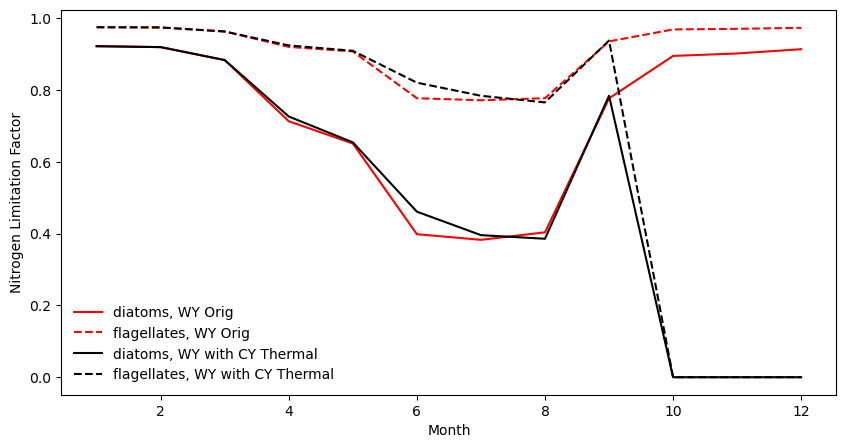

In [33]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
months=np.arange(1,13)
ax.plot(months,DiatLimOrig['NLim'],'r-',label='diatoms, WY Orig')
ax.plot(months,NanoLimOrig['NLim'],'r--',label='flagellates, WY Orig')
ax.plot(months,DiatLimExp['NLim'],'k-',label='diatoms, WY with CY Rivers')
ax.plot(months,NanoLimExp['NLim'],'k--',label='flagellates, WY with CY Rivers')
ax.legend(frameon=False)
ax.set_ylabel('Nitrogen Limitation Factor')
ax.set_xlabel('Month')

### Ratio of Diatom:Flagellate Nitrogen Response Factors

/tmp/ipykernel_1104006/150557752.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(months,DiatLimExp['NLim']/NanoLimExp['NLim'],'k--',label='WY with CY Rivers')


Text(0.5, 0, 'Month')

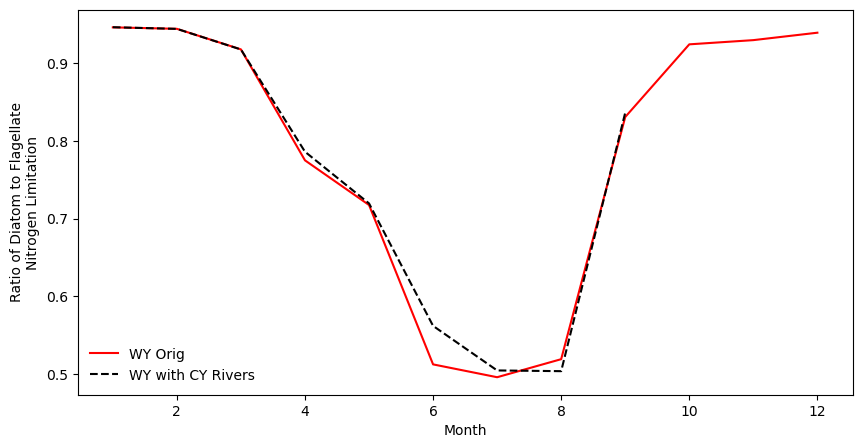

In [35]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
months=np.arange(1,13)
ax.plot(months,DiatLimOrig['NLim']/NanoLimOrig['NLim'],'r-',label='WY Orig')
ax.plot(months,DiatLimExp['NLim']/NanoLimExp['NLim'],'k--',label='WY with CY Rivers')
ax.legend(frameon=False)
ax.set_ylabel('Ratio of Diatom to Flagellate\nNitrogen Limitation')
ax.set_xlabel('Month')

### Silicate Response Factors

Text(0.5, 0, 'Month')

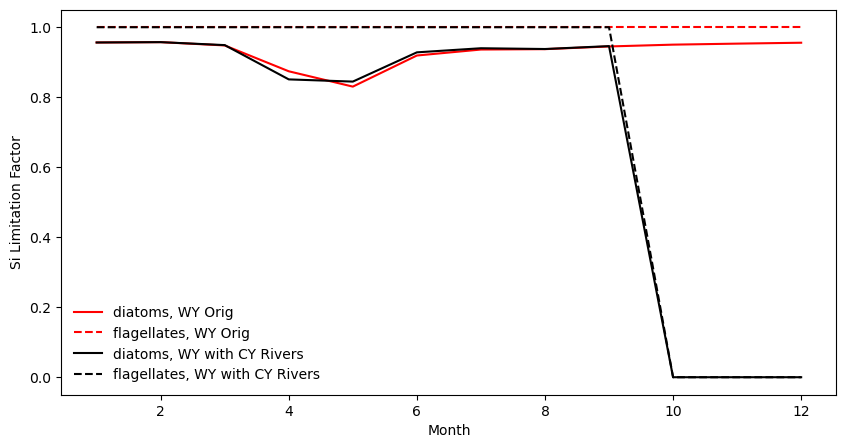

In [36]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
months=np.arange(1,13)
ax.plot(months,DiatLimOrig['SiLim'],'r-',label='diatoms, WY Orig')
ax.plot(months,NanoLimOrig['SiLim'],'r--',label='flagellates, WY Orig')
ax.plot(months,DiatLimExp['SiLim'],'k-',label='diatoms, WY with CY Rivers')
ax.plot(months,NanoLimExp['SiLim'],'k--',label='flagellates, WY with CY Rivers')
ax.legend(frameon=False)
ax.set_ylabel('Si Limitation Factor')
ax.set_xlabel('Month')

### Overall nutrient response factors

Text(0.5, 0, 'Month')

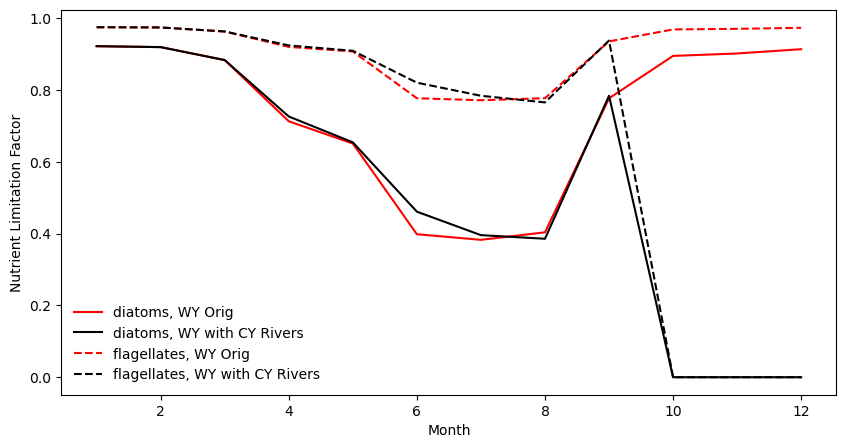

In [37]:
NutLimDiatOrig=np.where(DiatLimOrig['SiLim']<DiatLimOrig['NLim'],DiatLimOrig['SiLim'],DiatLimOrig['NLim'])
NutLimNanoOrig=NanoLimOrig['NLim']
NutLimDiatExp=np.where(DiatLimExp['SiLim']<DiatLimExp['NLim'],DiatLimExp['SiLim'],DiatLimExp['NLim'])
NutLimNanoExp=NanoLimExp['NLim']

fig,ax=plt.subplots(1,1,figsize=(10,5))
months=np.arange(1,13)
ax.plot(months,NutLimDiatOrig,'r-',label='diatoms, WY Orig')
ax.plot(months,NutLimDiatExp,'k-',label='diatoms, WY with CY Rivers')
ax.plot(months,NutLimNanoOrig,'r--',label='flagellates, WY Orig')
ax.plot(months,NutLimNanoExp,'k--',label='flagellates, WY with CY Rivers')
ax.legend(frameon=False)
ax.set_ylabel('Nutrient Limitation Factor')
ax.set_xlabel('Month')

### Ratio of Diatom:Flagellate Nutrient Response Factors

/tmp/ipykernel_1104006/851252276.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(months,NutLimDiatExp/NutLimNanoExp,'k--',label='WY with CY Rivers')


Text(0.5, 0, 'Month')

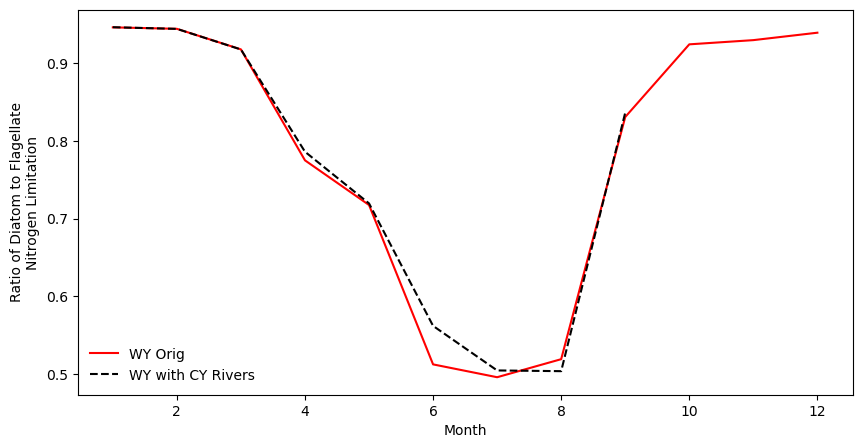

In [38]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
months=np.arange(1,13)
ax.plot(months,NutLimDiatOrig/NutLimNanoOrig,'r-',label='WY Orig')
ax.plot(months,NutLimDiatExp/NutLimNanoExp,'k--',label='WY with CY Rivers')
ax.legend(frameon=False)
ax.set_ylabel('Ratio of Diatom to Flagellate\nNitrogen Limitation')
ax.set_xlabel('Month')

### Nutrient and Temperature Response Factor Ratios (diatom:flagellate) on same axes

/tmp/ipykernel_1104006/3049363901.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(months,NutLimDiatExp/NutLimNanoExp,'k-',label='WY with CY Rivers, Nutrients')


Text(0.5, 0, 'Month')

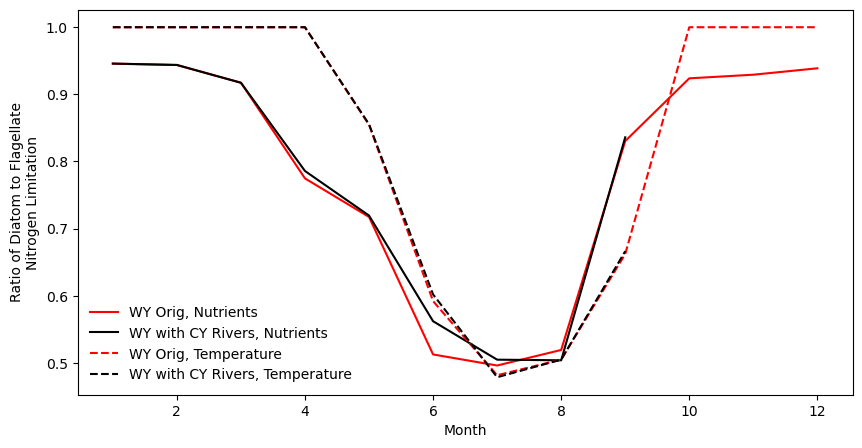

In [39]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
months=np.arange(1,13)
ax.plot(months,NutLimDiatOrig/NutLimNanoOrig,'r-',label='WY Orig, Nutrients')
ax.plot(months,NutLimDiatExp/NutLimNanoExp,'k-',label='WY with CY Rivers, Nutrients')
ax.plot(months,TdepDiatOrig/TdepNanoOrig,'--',color='r',label='WY Orig, Temperature')
ax.plot(months,TdepDiatExp/TdepNanoExp,'--',color='k',label='WY with CY Rivers, Temperature')
ax.legend(frameon=False)
ax.set_ylabel('Ratio of Diatom to Flagellate\nNitrogen Limitation')
ax.set_xlabel('Month')

### Now plot diatom to flagellate overall growth ratios (multiply by max growth) when temperature and nutrient responses are considered in isolation:

###### * these rates would never occur in the model, even under repleat/optimal conditions, as the maximum of the nutrient and temperature responses are not equal to 1.

In [40]:
mumaxDiat=nml['zz_rate_r_diat']
mumaxNano=nml['zz_rate_r_nano']

/tmp/ipykernel_1104006/3409053882.py:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xticks,mumaxDiat/mumaxNano*NutLimDiatExp/NutLimNanoExp,'k--',label='WY with CY Rivers Nutrient dependence only')


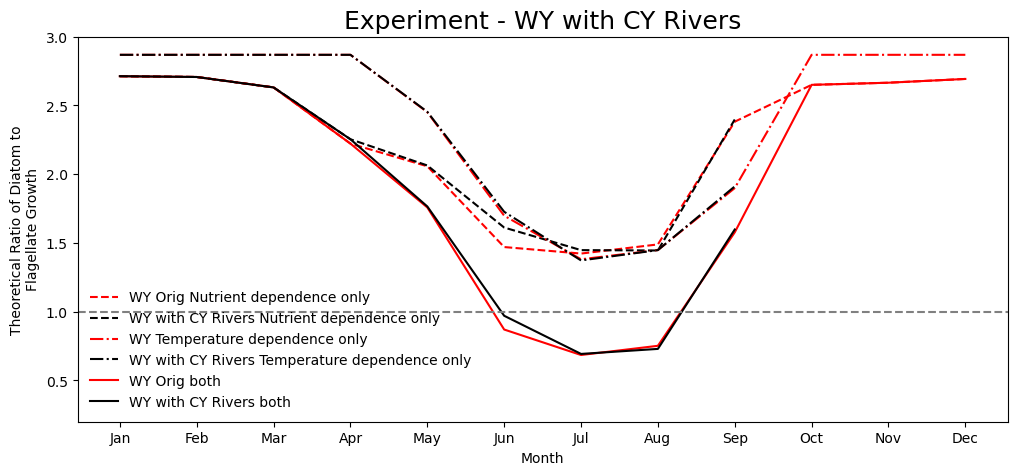

In [42]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
months=np.arange(1,13)
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]

ax.plot(xticks,mumaxDiat/mumaxNano*NutLimDiatOrig/NutLimNanoOrig,'r--',label='WY Orig Nutrient dependence only')
ax.plot(xticks,mumaxDiat/mumaxNano*NutLimDiatExp/NutLimNanoExp,'k--',label='WY with CY Rivers Nutrient dependence only')
ax.plot(xticks,mumaxDiat/mumaxNano*TdepDiatOrig/TdepNanoOrig,'-.',color='r',label='WY Temperature dependence only')
ax.plot(xticks,mumaxDiat/mumaxNano*TdepDiatExp/TdepNanoExp,'-.',color='k',label='WY with CY Rivers Temperature dependence only')
ax.plot(xticks,mumaxDiat/mumaxNano*TdepDiatOrig/TdepNanoOrig*NutLimDiatOrig/NutLimNanoOrig,'-',color='r',label='WY Orig both')
ax.plot(xticks,mumaxDiat/mumaxNano*TdepDiatExp/TdepNanoExp*NutLimDiatExp/NutLimNanoExp,'-',color='k',label='WY with CY Rivers both')
ax.legend(frameon=False)
ax.set_ylabel('Theoretical Ratio of Diatom to\nFlagellate Growth')
ax.set_xlabel('Month')
ax.set_ylim(0.2,3.0)
ax.set_title('Experiment - WY with CY Rivers',fontsize=18)
ax.axhline(y=1.0,color='grey',linestyle='--')

#choose 2 colours; 1 for 2008 and 1 for 2019; use solid for the final "both" plots
# diff. mortality rates for diatoms/flagellates - how will this effect things?
# response of light function might shift things a small amount